<a href="https://colab.research.google.com/github/akshita119/vehicleNumberPlateRecognition/blob/main/numberPlateExtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"akshita119","key":"b83a12403e6e1a0e59856c60d199c23a"}'}

In [2]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [3]:
!kaggle datasets download -d aslanahmedov/number-plate-detection

Dataset URL: https://www.kaggle.com/datasets/aslanahmedov/number-plate-detection
License(s): copyright-authors
 97% 400M/413M [00:03<00:00, 106MB/s]
100% 413M/413M [00:03<00:00, 137MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('number-plate-detection.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import os
import shutil
import random

os.makedirs("/content/data", exist_ok=True)
os.makedirs("/content/data/train", exist_ok=True)
os.makedirs("/content/data/test", exist_ok=True)
os.makedirs("/content/data/val", exist_ok=True)

input_folder = '/content/images'
output_folder = '/content/data'
train_folder = os.path.join(output_folder, 'train')
val_folder = os.path.join(output_folder, 'val')
test_folder = os.path.join(output_folder, 'test')

os.makedirs(os.path.join(train_folder, 'images'), exist_ok=True)
os.makedirs(os.path.join(train_folder, 'labels'), exist_ok=True)
os.makedirs(os.path.join(val_folder, 'images'), exist_ok=True)
os.makedirs(os.path.join(val_folder, 'labels'), exist_ok=True)
os.makedirs(os.path.join(test_folder, 'images'), exist_ok=True)
os.makedirs(os.path.join(test_folder, 'labels'), exist_ok=True)

image_files = [f for f in os.listdir(input_folder) if f.endswith('.jpeg')]
xml_files = [f for f in os.listdir(input_folder) if f.endswith('.xml')]


random.shuffle(image_files)
# splitting into 80 15 5 -> train val test

total_images = len(image_files)
train_end = int(0.8 * total_images)
val_end = int(0.95 * total_images)

train_images = image_files[:train_end]
val_images = image_files[train_end:val_end]
test_images = image_files[val_end:]



def copy_files(file_list, source_folder, dest_folder):
    for file in file_list:
        try:
            shutil.copy(os.path.join(source_folder, file), os.path.join(dest_folder, 'images', file))
            xml_file = file.replace('.jpeg', '.xml')
            shutil.copy(os.path.join(source_folder, xml_file), os.path.join(dest_folder, 'labels', xml_file))

        except FileNotFoundError:
            print(f"file not found: {file} or its XML file.")
        except Exception as e:
            print(f"error in {file} : {e}")


copy_files(train_images, input_folder, train_folder)
copy_files(val_images, input_folder, val_folder)
copy_files(test_images, input_folder, test_folder)

print("done splitting")


file not found: N182.jpeg or its XML file.
file not found: N249.jpeg or its XML file.
file not found: N180.jpeg or its XML file.
done splitting


In [6]:
# for pascal to yolo conversion
import xml.etree.ElementTree as ET

# labels
train_labels_path = '/content/data/train/labels'
val_labels_path = '/content/data/val/labels'
test_labels_path = '/content/data/test/labels'


def convert_voc_to_yolo(xml_file, image_width, image_height):
    yolo_annotations = []

    # parse xml
    tree = ET.parse(xml_file)
    root = tree.getroot()

    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        # yolo form
        x_center = (xmin + xmax) / 2 / image_width
        y_center = (ymin + ymax) / 2 / image_height
        width = (xmax - xmin) / image_width
        height = (ymax - ymin) / image_height

        yolo_annotations.append(f"0 {x_center} {y_center} {width} {height}")

    return yolo_annotations


def process_folder(folder_path):
    for xml_file in os.listdir(folder_path):
        if xml_file.endswith('.xml'):
            xml_path = os.path.join(folder_path, xml_file)

            image_name = os.path.splitext(xml_file)[0] + '.jpeg'

            tree = ET.parse(xml_path)
            root = tree.getroot()
            size = root.find('size')
            width = int(size.find('width').text)
            height = int(size.find('height').text)

            yolo_annot = convert_voc_to_yolo(xml_path, width, height)     # annotations in yolo

            # make .txt
            yolo_file_path = os.path.join(folder_path, image_name.replace('.jpeg', '.txt'))
            with open(yolo_file_path, 'w') as yolo_file:
                for annotation in yolo_annot:
                    yolo_file.write(annotation + '\n')


process_folder(train_labels_path)
process_folder(val_labels_path)
process_folder(test_labels_path)

print("converted psacal to yolo")


converted psacal to yolo


In [7]:
# deleting xml

label_directories = [
    '/content/data/train/labels',
    '/content/data/val/labels',
    '/content/data/test/labels'
]

def remove_xml_files(dir):
    for filename in os.listdir(dir):
        if filename.endswith('.xml'):
            file_path = os.path.join(dir, filename)
            os.remove(file_path)

for label_dir in label_directories:
    remove_xml_files(label_dir)




In [8]:
shutil.rmtree("/content/images")
shutil.move('/content/data.yaml', '/content/data/data.yaml')   # move yaml to data dir

'/content/data/data.yaml'

In [9]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 14.8 MB/s eta 0:00:00


In [10]:
!pip install torch torchvision


In [11]:
! git clone https://github.com/ultralytics/ultralytics.git


Cloning into 'ultralytics'...
remote: Enumerating objects: 45138, done.
remote: Total 45138 (delta 0), reused 0 (delta 0), pack-reused 45138 (from 1)
Receiving objects: 100% (45138/45138), 37.72 MiB | 27.51 MiB/s, done.
Resolving deltas: 100% (33635/33635), done.


In [12]:
%cd /content

/content


In [13]:
!nvidia-smi


Fri Nov  1 07:24:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/data/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tru

train: Scanning /content/data/train/labels.cache... 181 images, 1 backgrounds, 0 corrupt: 100%|██████████| 182/182 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/data/val/labels.cache... 33 images, 1 backgrounds, 0 corrupt: 100%|██████████| 34/34 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.63G      1.538      3.791      1.416         15        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

                   all         34         33    0.00304      0.939      0.602      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.44G      1.145      2.352      1.084         16        640: 100%|██████████| 12/12 [00:06<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]

                   all         34         33    0.00324          1       0.82      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.44G      1.175      1.855       1.14         11        640: 100%|██████████| 12/12 [00:03<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.15it/s]

                   all         34         33    0.00324          1      0.584      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.44G      1.279      1.825      1.123         13        640: 100%|██████████| 12/12 [00:03<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.56it/s]

                   all         34         33      0.623      0.601      0.588       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.45G      1.246      1.755      1.107         12        640: 100%|██████████| 12/12 [00:04<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         34         33      0.455      0.394      0.518      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.44G      1.214      1.618      1.093         13        640: 100%|██████████| 12/12 [00:03<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         34         33      0.604      0.485      0.508      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.44G      1.223      1.525      1.159         14        640: 100%|██████████| 12/12 [00:03<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

                   all         34         33      0.448      0.515      0.503      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.44G      1.254      1.554      1.156         14        640: 100%|██████████| 12/12 [00:03<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]

                   all         34         33      0.674      0.627      0.671      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.44G      1.243      1.405      1.117         15        640: 100%|██████████| 12/12 [00:05<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.45it/s]

                   all         34         33      0.865      0.818       0.85      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.44G      1.258      1.434      1.168         10        640: 100%|██████████| 12/12 [00:03<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.89it/s]

                   all         34         33      0.749      0.902      0.851      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.44G      1.241      1.309      1.146         11        640: 100%|██████████| 12/12 [00:03<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.10it/s]

                   all         34         33      0.727      0.818      0.841      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.44G      1.169      1.246       1.11         17        640: 100%|██████████| 12/12 [00:04<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]

                   all         34         33      0.698      0.909      0.842       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.44G      1.227      1.243      1.121         18        640: 100%|██████████| 12/12 [00:03<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.51it/s]

                   all         34         33      0.751      0.758      0.803      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.44G      1.187      1.226       1.12         15        640: 100%|██████████| 12/12 [00:03<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.87it/s]

                   all         34         33      0.907      0.884      0.922       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.44G      1.151      1.127      1.086         13        640: 100%|██████████| 12/12 [00:03<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all         34         33      0.904      0.909      0.941      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.44G      1.146      1.113       1.08         13        640: 100%|██████████| 12/12 [00:04<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

                   all         34         33      0.906      0.875      0.949       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.44G      1.126      1.036      1.077         12        640: 100%|██████████| 12/12 [00:03<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.13it/s]

                   all         34         33      0.942      0.909       0.97      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.44G      1.119      1.059      1.088          9        640: 100%|██████████| 12/12 [00:03<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all         34         33      0.841      0.959      0.949      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.44G      1.126     0.9894      1.082         14        640: 100%|██████████| 12/12 [00:04<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         34         33      0.963      0.939      0.988      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.44G      1.171      1.051      1.093         14        640: 100%|██████████| 12/12 [00:03<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.90it/s]

                   all         34         33      0.861      0.936      0.946      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.44G      1.125     0.9263      1.073         12        640: 100%|██████████| 12/12 [00:03<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.39it/s]

                   all         34         33      0.939          1      0.992      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.44G      1.133     0.9281      1.061         11        640: 100%|██████████| 12/12 [00:04<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]

                   all         34         33      0.962       0.97      0.993      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.44G      1.057     0.8504       1.04         14        640: 100%|██████████| 12/12 [00:03<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.96it/s]

                   all         34         33       0.97      0.995      0.993      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.44G      1.119     0.9037      1.101          8        640: 100%|██████████| 12/12 [00:03<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]

                   all         34         33      0.916      0.994      0.989      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.44G      1.065     0.8885      1.064         11        640: 100%|██████████| 12/12 [00:03<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

                   all         34         33      0.913      0.909      0.962      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.44G      1.066     0.8589       1.08          7        640: 100%|██████████| 12/12 [00:04<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.04it/s]

                   all         34         33       0.88      0.885      0.958       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.44G      1.066     0.8264      1.076          7        640: 100%|██████████| 12/12 [00:03<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.36it/s]

                   all         34         33      0.919      0.879      0.927      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.44G      1.081     0.8471      1.055         14        640: 100%|██████████| 12/12 [00:03<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.89it/s]

                   all         34         33      0.951      0.909      0.973      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.44G      1.073     0.8028      1.034         11        640: 100%|██████████| 12/12 [00:04<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]

                   all         34         33      0.969      0.932      0.952      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.44G      1.069     0.8231      1.027         14        640: 100%|██████████| 12/12 [00:03<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.27it/s]

                   all         34         33      0.939      0.936      0.964        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.44G     0.9669     0.7531      1.028          9        640: 100%|██████████| 12/12 [00:03<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.61it/s]

                   all         34         33      0.969      0.958      0.979      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.44G     0.9864     0.7586      1.012         15        640: 100%|██████████| 12/12 [00:03<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]

                   all         34         33      0.996       0.97      0.994      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.44G      0.989     0.7527      1.013          9        640: 100%|██████████| 12/12 [00:04<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.22it/s]

                   all         34         33      0.969      0.958      0.991      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.44G      1.065     0.7908      1.077         15        640: 100%|██████████| 12/12 [00:02<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         34         33      0.968      0.939      0.992      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.44G      1.039     0.7457      1.047         16        640: 100%|██████████| 12/12 [00:03<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         34         33      0.995      0.939      0.989      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.45G     0.9621     0.7083     0.9975         11        640: 100%|██████████| 12/12 [00:04<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all         34         33      0.993       0.97       0.99       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.44G     0.9965      0.703      1.033         13        640: 100%|██████████| 12/12 [00:03<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.95it/s]

                   all         34         33      0.987       0.97      0.992      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.44G      0.941     0.6814          1          9        640: 100%|██████████| 12/12 [00:03<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.01it/s]

                   all         34         33      0.965          1      0.987      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.44G     0.9931     0.7051      1.041         10        640: 100%|██████████| 12/12 [00:04<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]

                   all         34         33      0.959      0.939      0.977       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.44G      1.037     0.7322      1.009         10        640: 100%|██████████| 12/12 [00:04<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]

                   all         34         33      0.959      0.939      0.973      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.44G     0.9653     0.6953      1.008         14        640: 100%|██████████| 12/12 [00:03<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.27it/s]

                   all         34         33      0.968      0.939      0.972      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.44G     0.9499     0.6727      1.016          9        640: 100%|██████████| 12/12 [00:03<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]


                   all         34         33      0.969       0.97      0.965      0.611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.45G      1.006     0.7041      1.015         13        640: 100%|██████████| 12/12 [00:05<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]

                   all         34         33       0.97      0.966      0.986      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.44G     0.9294     0.6712      0.978         11        640: 100%|██████████| 12/12 [00:03<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.34it/s]

                   all         34         33          1      0.869      0.963      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.44G      0.921      0.676      1.007         10        640: 100%|██████████| 12/12 [00:03<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.66it/s]

                   all         34         33      0.909      0.904      0.935      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.44G     0.9251     0.6318     0.9981         13        640: 100%|██████████| 12/12 [00:04<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]

                   all         34         33      0.967      0.878      0.942      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.44G     0.9994     0.6719      1.045          8        640: 100%|██████████| 12/12 [00:03<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.25it/s]

                   all         34         33      0.963      0.879      0.943      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.44G     0.8959      0.637     0.9781         10        640: 100%|██████████| 12/12 [00:03<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]

                   all         34         33      0.948       0.97      0.988      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.44G     0.9128     0.6276      1.004          6        640: 100%|██████████| 12/12 [00:03<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.69it/s]

                   all         34         33       0.99       0.97      0.993      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.44G     0.9083     0.6017     0.9923          9        640: 100%|██████████| 12/12 [00:04<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.71it/s]

                   all         34         33      0.996       0.97      0.993      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.44G     0.8791     0.6166     0.9733          9        640: 100%|██████████| 12/12 [00:02<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]

                   all         34         33          1      0.967      0.989      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.44G      0.909     0.6193     0.9799         11        640: 100%|██████████| 12/12 [00:03<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.01it/s]

                   all         34         33       0.97      0.965      0.975      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.44G     0.8335     0.5677     0.9682          9        640: 100%|██████████| 12/12 [00:04<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all         34         33      0.967      0.939      0.973      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.44G     0.8347     0.5885     0.9711         15        640: 100%|██████████| 12/12 [00:03<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.17it/s]

                   all         34         33      0.939      0.928      0.971      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.44G     0.8733     0.5918     0.9752         12        640: 100%|██████████| 12/12 [00:03<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.45it/s]

                   all         34         33      0.993       0.97      0.993      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.44G     0.8336     0.5731     0.9632         17        640: 100%|██████████| 12/12 [00:03<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


                   all         34         33       0.99          1      0.995      0.636

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.44G     0.8839     0.5583     0.9613         14        640: 100%|██████████| 12/12 [00:03<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.52it/s]

                   all         34         33      0.993          1      0.995      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.44G     0.8475     0.5575     0.9686         13        640: 100%|██████████| 12/12 [00:02<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.47it/s]

                   all         34         33      0.966          1      0.994      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.44G      0.861     0.5552     0.9838         13        640: 100%|██████████| 12/12 [00:02<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all         34         33      0.993       0.97      0.993      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.44G     0.8816     0.5442     0.9699         11        640: 100%|██████████| 12/12 [00:05<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

                   all         34         33          1      0.964      0.993      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.44G     0.8313     0.5802     0.9621         13        640: 100%|██████████| 12/12 [00:03<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.92it/s]

                   all         34         33      0.964       0.97      0.989      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.44G     0.8282     0.5546     0.9591         11        640: 100%|██████████| 12/12 [00:03<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.65it/s]

                   all         34         33      0.979      0.939      0.989      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.44G     0.8072     0.5429      0.962          6        640: 100%|██████████| 12/12 [00:04<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]

                   all         34         33      0.939          1      0.988      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.44G     0.8209     0.5244     0.9444         16        640: 100%|██████████| 12/12 [00:03<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.42it/s]

                   all         34         33      0.916      0.997      0.989      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.44G     0.8141     0.5568     0.9688         11        640: 100%|██████████| 12/12 [00:03<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.98it/s]

                   all         34         33      0.997       0.97       0.99      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.44G     0.8319     0.5261     0.9663         17        640: 100%|██████████| 12/12 [00:03<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]

                   all         34         33      0.997       0.97      0.988      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.44G     0.7695     0.5215     0.9276          6        640: 100%|██████████| 12/12 [00:04<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.97it/s]

                   all         34         33      0.998          1      0.995      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.44G     0.8138     0.5411     0.9521         13        640: 100%|██████████| 12/12 [00:02<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.08it/s]

                   all         34         33      0.965          1      0.994      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.44G     0.7982     0.5434     0.9494         14        640: 100%|██████████| 12/12 [00:03<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.52it/s]

                   all         34         33          1      0.996      0.995      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.44G     0.7848     0.5155     0.9433         13        640: 100%|██████████| 12/12 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]

                   all         34         33      0.976       0.97      0.993      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.44G      0.757     0.5023     0.9342         14        640: 100%|██████████| 12/12 [00:03<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.14it/s]

                   all         34         33      0.965       0.97      0.992      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.45G     0.7401      0.502     0.9371         14        640: 100%|██████████| 12/12 [00:02<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]

                   all         34         33       0.97      0.988      0.993      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.44G     0.7786     0.5037     0.9544         12        640: 100%|██████████| 12/12 [00:03<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         34         33      0.967       0.97      0.993      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.44G     0.7623     0.5124     0.9487          7        640: 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.67it/s]

                   all         34         33       0.97          1      0.994      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.44G     0.7695     0.5074     0.9339         16        640: 100%|██████████| 12/12 [00:02<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]

                   all         34         33      0.997       0.97      0.994      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.45G     0.7188     0.5059     0.9231         17        640: 100%|██████████| 12/12 [00:03<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.16it/s]

                   all         34         33       0.97          1      0.994      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.44G      0.736     0.4785     0.9378         14        640: 100%|██████████| 12/12 [00:04<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         34         33       0.97      0.996      0.993       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.44G     0.7031     0.4656     0.9157         15        640: 100%|██████████| 12/12 [00:03<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.37it/s]

                   all         34         33      0.969       0.97      0.993      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.44G     0.7514     0.4908     0.9223         13        640: 100%|██████████| 12/12 [00:02<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.34it/s]

                   all         34         33       0.97      0.995      0.993      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.44G      0.697     0.4659     0.9134         11        640: 100%|██████████| 12/12 [00:03<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

                   all         34         33       0.96          1      0.993      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.44G     0.6999     0.4638     0.9239         10        640: 100%|██████████| 12/12 [00:03<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.28it/s]

                   all         34         33      0.959          1      0.993      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.44G     0.7289     0.4765     0.9125         10        640: 100%|██████████| 12/12 [00:03<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.10it/s]

                   all         34         33       0.97      0.986      0.993      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.45G     0.6958      0.472     0.9376         12        640: 100%|██████████| 12/12 [00:03<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.16it/s]

                   all         34         33      0.941          1      0.993      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.44G     0.7248     0.4841     0.9237         11        640: 100%|██████████| 12/12 [00:04<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.47it/s]

                   all         34         33      0.966       0.97      0.993      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.44G     0.6962     0.4641     0.9233         17        640: 100%|██████████| 12/12 [00:02<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.78it/s]

                   all         34         33      0.969          1      0.994      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.44G     0.6742     0.4423     0.9128         10        640: 100%|██████████| 12/12 [00:03<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.28it/s]

                   all         34         33          1      0.992      0.995      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.44G      0.653      0.451     0.8929         17        640: 100%|██████████| 12/12 [00:04<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


                   all         34         33      0.968          1      0.994      0.683

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.44G     0.6744     0.4575     0.9205          7        640: 100%|██████████| 12/12 [00:04<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.44it/s]

                   all         34         33      0.984       0.97      0.993      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.44G     0.6778      0.452     0.9263         15        640: 100%|██████████| 12/12 [00:03<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.27it/s]

                   all         34         33       0.98       0.97       0.99      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.44G     0.6739     0.4534     0.9089         16        640: 100%|██████████| 12/12 [00:03<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]

                   all         34         33      0.971      0.997      0.994      0.666


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      3.44G     0.6211     0.4496     0.8962          6        640: 100%|██████████| 12/12 [00:06<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.26it/s]

                   all         34         33      0.971      0.998      0.993      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      3.44G      0.593     0.4293      0.878          6        640: 100%|██████████| 12/12 [00:03<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]

                   all         34         33      0.971      0.999      0.994      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      3.44G      0.591     0.4068     0.8588          6        640: 100%|██████████| 12/12 [00:03<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         34         33      0.971      0.999      0.988      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      3.44G     0.6018     0.4234     0.8938          6        640: 100%|██████████| 12/12 [00:04<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]

                   all         34         33      0.967       0.97      0.988      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      3.44G     0.5715     0.3946     0.8542          6        640: 100%|██████████| 12/12 [00:03<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.16it/s]

                   all         34         33      0.967       0.97      0.985      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      3.44G     0.5683     0.3942     0.8887          6        640: 100%|██████████| 12/12 [00:02<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.97it/s]

                   all         34         33      0.967       0.97      0.987      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      3.44G     0.5875     0.3968     0.8627          6        640: 100%|██████████| 12/12 [00:04<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]

                   all         34         33      0.966       0.97      0.989      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      3.44G     0.5727      0.392     0.8693          6        640: 100%|██████████| 12/12 [00:03<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.09it/s]

                   all         34         33      0.966       0.97      0.989      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      3.44G      0.557      0.406      0.869          6        640: 100%|██████████| 12/12 [00:02<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.85it/s]

                   all         34         33      0.965       0.97      0.989      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      3.44G     0.5421     0.3881     0.8597          6        640: 100%|██████████| 12/12 [00:03<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]

                   all         34         33      0.966       0.97      0.989      0.643



100 epochs completed in 0.146 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 5.5MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]


                   all         34         33      0.964       0.97      0.989      0.699
Speed: 0.3ms preprocess, 5.0ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/train2
Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /content/data/val/labels.cache... 33 images, 1 backgrounds, 0 corrupt: 100%|██████████| 34/34 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


                   all         34         33      0.995      0.939      0.989      0.691
Speed: 1.0ms preprocess, 20.2ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train22

image 1/1 /content/data/test/images/N53.jpeg: 352x640 1 number_plate, 45.8ms
Speed: 2.1ms preprocess, 45.8ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)


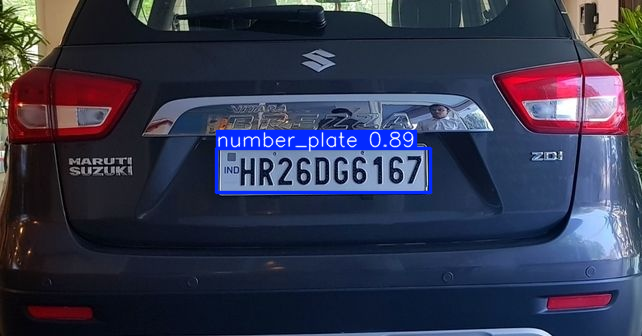

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (Intel Xeon 2.30GHz)

PyTorch: starting from 'runs/detect/train2/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (5.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 210.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 205.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.2/226.2 MB 141.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 163.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 192.8 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 19.7s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: sli

In [15]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11n.pt")

# Train the model
train_results = model.train(
    data="/content/data/data.yaml",  # path to dataset YAML
    epochs=100,  # number of training epochs
    imgsz=640,  # training image size
    device="0",  # device to run on, i.e. device=0 or device=0,1,2,3 or device=cpu
)

# Evaluate model performance on the validation set
metrics = model.val()

# Perform object detection on an image
results = model("/content/data/test/images/N53.jpeg")
results[0].show()

# Export the model to ONNX format
path = model.export(format="onnx")  # return path to exported model

In [16]:
files.download('/content/runs/detect/train2/weights/best.onnx')
files.download('/content/runs/detect/train2/weights/best.pt')
files.download('/content/runs/detect/train2/weights/last.pt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>